In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
from scipy import stats
import scikits.bootstrap as boot
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel,wilcoxon
import os,math,mat73,sys
sys.path.append('../utility/')
from functions import mybarplot,fisherztrans,myheatmap
from joblib import Parallel, delayed
from datetime import datetime

### set parameters

%cd /home/yuqiyou/faceprf_dataprocesscode/faceprf_vol

subjs = ['CN040','CN041','CN042','CN043','CN044','CN045','CN055','CN056']
hemi = ['lh','rh']
tasks = ['face','fixation']
roi_labels = ['V1','V2','V3','hV4','IOG','pFus','mFus']

nsubj = len(subjs)
nvoxel = 100
ntrial = 1280
ntrialperpos = 80
npos=16
ds0 = 2 # degree

cm = np.array([[255, 107, 129],[112, 161, 255]])/255

ds_list = np.zeros((npos,npos))
for s1 in range(npos):
    r1 = s1//4
    c1 = s1%4
    for s2 in range(s1):
        r2 = s2//4
        c2 = s2%4
        ds_list[s1,s2] = ((r1-r2)**2+(c1-c2)**2)**0.5*ds0
d = np.unique(ds_list)[1:]

nsample = nsubj * np.max([ds_list[ds_list==dd].shape for dd in d[1:]])

ps_list = np.zeros(npos)
for s in range(npos):
    sr = s//4*2
    sc = s%4*2
    ps_list[s] = ((5-sr)**2+(5-sc)**2)**0.5
posd = np.unique(ps_list)
nsample0 = nsubj * np.max([ps_list[ps_list==pp].shape for pp in posd])


In [ ]:
## Load data

data = np.load('data/selectdata-both.npz',allow_pickle=True)
stimposicond_all = data['stimposicond_all']
v_sel_all = data['v_sel_all']
r2_sel_all = data['r2_sel_all']
beta_all = data['beta_sel_all']
prf_sel_all = data['prf_sel_all']

# stimposicond_all: [tasks * trial x sample]
# v_sel_all : roi x sample x voxel, from 0
# r2_sel_all : roi x sample x voxel x 2[glmr2,prfr2]
# beta_sel_all: task x roi x sample x voxel x trial
# prf_sel_all: task x roi x sample x voxel x 8

### 1 SVM classification


In [ ]:
clf = svm.SVC(C=1,kernel='linear',gamma='scale',degree=3)
y = np.hstack([np.zeros(ntrialperpos),np.zeros(ntrialperpos)+1])
acc_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npos(s1),npos(s2),nsubj,nroi,ntask]

for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
            for s1 in range(npos):
                for s2 in range(s1,npos):  
                    X = np.hstack([beta[:,:,s1],beta[:,:,s2]]).T
                    X = X[:,~np.isnan(X).any(axis=0)]
                    scores = cross_val_score(clf,X,y,cv=10,n_jobs=35)
                    acc_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = np.array([scores.mean(),scores.mean()])

# concat reuslts by distance
acc_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            acc_dd = np.array([])
            for subj_i in range(len(subjs)):
                acc_dd = np.append(acc_dd,acc_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
            acc_d[dd,0:len(acc_dd),roi_i,task_i] = acc_dd


# average accuracy across position pairs for each distance for each subject
acc_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    acc_d_subj[dd,:,:,:] = np.nanmean(acc_ij_all[ds_list==d[dd],:,:,:],axis=0)

np.savez('data/svmacc',acc_ij_all=acc_ij_all,acc_d=acc_d,acc_d_subj=acc_d_subj)           

### 2 individual level

#### 2.0 vRF

In [4]:
vRF_allv = prf_sel_all # ntask x nroi x nsubj x nvoxel x 8
vRF_all = np.nanmedian(vRF_allv,axis=3) # ntask x nroi x nsubj x 8
# 0-R2, 1-x, 2-y, 3-ecc, 4-ang, 5-size, 6-expt, 7-gain
%cd /home/yuqiyou/faceprf_dataprocesscode/faceprf_vol
np.savez('data/vRF',vRF_allv=vRF_allv,vRF_all=vRF_all)                       

/home/yuqiyou/faceprf_dataprocesscode/faceprf_vol


#### 2.1 Fano Factor

The ratio of the variance to the mean is often called the **Fano factor** and is a measure of the variability in the number of spikes in relation to the mean number of spikes:

$$
FF(T)≡\frac{σ_{N(0,T)}^2}{m_{N(0,T)}}
$$
$$
FF_i = \frac{v_i}{b_i}
$$
$$
FF^n = median(FF_i)
$$


In [ ]:
# calculate
FF_p_all = np.zeros((npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npos(s1),nsubj,nroi,ntask]
FFv_all = np.zeros((nvoxel,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [nvoxel,npos(s1),nsubj,nroi,ntask]
FF2_p_all = np.zeros((npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npos(s1),nsubj,nroi,ntask]
FF2v_all = np.zeros((nvoxel,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [nvoxel,npos(s1),nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
                v = np.var(beta[:,:,pos],axis=1) # 100
                f = np.mat(beta_mean[:,pos]) # 1 x 100
                # 1 x 100
                # abs
                FF_n = np.multiply(v,abs(1/f))
                FFv_all[:,pos,subj_i,roi_i,task_i] = np.array(FF_n)
                FF_p_all[pos,subj_i,roi_i,task_i] = np.nanmedian(np.array(FF_n))
                # square
                FF2_n = np.square(FF_n)
                FFv_all[:,pos,subj_i,roi_i,task_i] = np.array(FF2_n)
                FF_p_all[pos,subj_i,roi_i,task_i] = np.nanmedian(np.array(FF2_n))

# concat data across position
FF_all = np.zeros((npos*nsubj,len(roi_labels),len(tasks)))*np.nan
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        c = np.array([])
        for subj_i in range(len(subjs)):
            c = np.append(c,FF_p_all[:,subj_i,roi_i,task_i])
        FF_all[:,roi_i,task_i] = c

FF2_all = np.zeros((npos*nsubj,len(roi_labels),len(tasks)))*np.nan
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        c = np.array([])
        for subj_i in range(len(subjs)):
            c = np.append(c,FF2_p_all[:,subj_i,roi_i,task_i])
        FF2_all[:,roi_i,task_i] = c


np.savez('data/FF',FF_p_all=FF_p_all,FF_all=FF_all,FFv_all=FFv_all,
         FF2_p_all=FF2_p_all,FF2_all=FF2_all,FF2v_all=FF2v_all)           

#### 2.2 Variance

In [ ]:
# calculate
rv_p_all = np.zeros((npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npos(s1),nsubj,nroi,ntask]
rvv_all = np.zeros((nvoxel,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [nvoxel,npos(s1),nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
                rvv_all[:,pos,subj_i,roi_i,task_i] = np.var(beta[:,:,pos],axis=1)
                rv_p_all[pos,subj_i,roi_i,task_i] = np.nanmedian(np.var(beta[:,:,pos],axis=1)) # 100
                
# concat data across position
rv_all = np.zeros((npos*nsubj,len(roi_labels),len(tasks)))*np.nan
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        c1 = np.array([])
        for subj_i in range(len(subjs)):
            c1 = np.append(c1,rv_p_all[:,subj_i,roi_i,task_i])
        rv_all[:,roi_i,task_i] = c1

np.savez('data/responsevariance',rv_p_all=rv_p_all,rv_all=rv_all,rvv_all=rvv_all)           

#### 2.3 noise correlation

In [ ]:
# calculate
corr_p_all = np.zeros((npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1), nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
            for s1 in range(npos):
                c = np.triu(np.corrcoef(beta[:,:,s1]),1) # 100 x 100 # 取上三角(不包括对角)
                corr_p_all[s1,subj_i,roi_i,task_i] = np.nanmedian(c[c!=0])
                #corr_p_all[s1,subj_i,roi_i,task_i] = fisherztrans(np.nanmedian(c[c!=0]))  # Fisher Z transformation

# concat data across position
corr_all = np.zeros((npos*nsubj,len(roi_labels),len(tasks)))*np.nan
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        c = np.array([])
        for subj_i in range(len(subjs)):
            c = np.append(c,corr_p_all[:,subj_i,roi_i,task_i])
        corr_all[:,roi_i,task_i] = c

np.savez('data/corr',corr_p_all=corr_p_all,corr_all=corr_all)  

### 3 LFI

#### 3.1 I_bc

In [4]:
def cal_lfi(beta_mean_cond,beta_cond,s1,s2,log=False):
    # ds
    dr = s1//4-s2//4
    dc = s1%4-s2%4
    ds = ds0 *  (dr**2+dc**2)**0.5
    # df & |dfnorm|
    df = np.mat(beta_mean_cond[:,s1] - beta_mean_cond[:,s2])
    dfnorm = np.linalg.norm(df,axis=1)
    # eigenvector & eigenvalue
    q1 = np.cov(beta_cond[:,:,s1])
    q2 = np.cov(beta_cond[:,:,s2])
    q = (q1 + q2)/2 # 100 x 100
    w,v = np.linalg.eigh(q)
    ullambda = np.nanmean(w)
    htlambda = w/ullambda
    # lfi
    lfi = dfnorm**2/ullambda*np.nansum([(df/dfnorm@v[:,i])**2/htlambda[i] for i in range(len(htlambda))])/(ds)**2
    #lfi = df@np.linalg.inv(q)@df.T/(ds)**2
    if log:
        lfi = np.log(lfi)
    return lfi,ds


$$I=\frac{df^T*S^{-1}*df}{ds^2}$$
$$\hat I_{bc}=I*\frac{2T-N-3}{2T-2}-\frac{2N}{Tds^2}$$

$S$ is the empirical covariance for each presented stimulus:
$$
S_1 = \frac{1}{T-1} \displaystyle\sum^T(\bold r - \bold f)^T(\bold r - \bold f)
$$



In [ ]:
# calculate
LFI_bc_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1),npos(s2),nsubj,nroi,ntask]
LFI_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1),npos(s2),nsubj,nroi,ntask]
logLFI_bc_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1),npos(s2),nsubj,nroi,ntask]
logLFI_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1),npos(s2),nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
            for s1 in range(npos-1):
                for s2 in range(s1+1,npos):
                    [LFI_ij,ds] = cal_lfi(beta_mean,beta,s1,s2)
                    LFI_bc_ij = LFI_ij*(2*ntrialperpos-nvoxel-3)/(2*ntrialperpos-2)-(2*nvoxel)/(ntrialperpos*(ds)**2)
                    LFI_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = LFI_ij
                    LFI_bc_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = LFI_bc_ij
                    logLFI_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = np.log(LFI_ij)
                    logLFI_bc_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = np.log(LFI_bc_ij)

                    
# concat reuslts by distance
LFI_bc_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
LFI_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
logLFI_bc_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
logLFI_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            LFI_bc_dd = np.array([])
            LFI_dd = np.array([])
            logLFI_bc_dd = np.array([])
            logLFI_dd = np.array([])
            for subj_i in range(len(subjs)):
                LFI_bc_dd = np.append(LFI_bc_dd,LFI_bc_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
                LFI_dd = np.append(LFI_dd,LFI_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
                logLFI_bc_dd = np.append(logLFI_bc_dd,logLFI_bc_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
                logLFI_dd = np.append(logLFI_dd,logLFI_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
            LFI_bc_d[dd,0:len(LFI_bc_dd),roi_i,task_i] = LFI_bc_dd
            LFI_d[dd,0:len(LFI_bc_dd),roi_i,task_i] = LFI_dd
            logLFI_bc_d[dd,0:len(LFI_bc_dd),roi_i,task_i] = logLFI_bc_dd
            logLFI_d[dd,0:len(LFI_bc_dd),roi_i,task_i] = logLFI_dd

# average LFI across position pairs for each distance for each subject
LFI_bc_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    LFI_bc_d_subj[dd,:,:,:] = np.nanmean(LFI_bc_ij_all[ds_list==d[dd],:,:,:],axis=0)
LFI_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    LFI_d_subj[dd,:,:,:] = np.nanmean(LFI_ij_all[ds_list==d[dd],:,:,:],axis=0)
logLFI_bc_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    logLFI_bc_d_subj[dd,:,:,:] = np.nanmean(logLFI_bc_ij_all[ds_list==d[dd],:,:,:],axis=0)
logLFI_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    logLFI_d_subj[dd,:,:,:] = np.nanmean(logLFI_ij_all[ds_list==d[dd],:,:,:],axis=0)


np.savez('data/LFI_bc',LFI_bc_ij_all=LFI_bc_ij_all,LFI_bc_d=LFI_bc_d,LFI_bc_d_subj=LFI_bc_d_subj,
         LFI_ij_all=LFI_ij_all,LFI_d=LFI_d,LFI_d_subj=LFI_d_subj,
         logLFI_bc_ij_all=logLFI_bc_ij_all,logLFI_bc_d=logLFI_bc_d,logLFI_bc_d_subj=logLFI_bc_d_subj,
         logLFI_ij_all=logLFI_ij_all,logLFI_d=logLFI_d,logLFI_d_subj=logLFI_d_subj)           

/tmp/ipykernel_98411/527264246.py:23: RuntimeWarning: invalid value encountered in log
  logLFI_bc_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = np.log(LFI_bc_ij)


#### 3.2 |df|

In [22]:
# calculate
dfnorm_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks))) # [npos(s1),npos(s2),nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta_sel_glmr2
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta_mean[:,pos] = np.nanmean(beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T,axis=1)
            for s1 in range(npos):
                dfnorm_ij_all[s1,:,subj_i,roi_i,task_i] = np.linalg.norm(beta_mean[:,s1] - beta_mean.T,axis=1)

# concat reuslts by distance
dfnorm_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            dfnorm_dd = np.array([])
            for subj_i in range(len(subjs)):
                dfnorm_dd = np.append(dfnorm_dd,dfnorm_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
            dfnorm_d[dd,0:len(dfnorm_dd),roi_i,task_i] = dfnorm_dd

# average dfnorm across position pairs for each distance for each subject
dfnorm_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    dfnorm_d_subj[dd,:,:,:] = np.nanmean(dfnorm_ij_all[ds_list==d[dd],:,:,:],axis=0)
        
np.savez('data/dfnorm',dfnorm_ij_all=dfnorm_ij_all,dfnorm_d=dfnorm_d,dfnorm_d_subj=dfnorm_d_subj)           

#### 3.3 mean variance

In [ ]:
# calculate
v_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npos,nsubj,nroi,ntask]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)): #[0,1,2,4,5,6,7]:#
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
            for s1 in range(npos):
                for s2 in range(s1,npos):
                    # eigenvector & eigenvalue
                    q1 = np.cov(beta[:,:,s1])
                    q2 = np.cov(beta[:,:,s2])
                    q = (q1 + q2)/2 # 100 x 100
                    '''
                    if np.isnan(q).any():
                        q=np.array(q)
                        q=q[~np.isnan(q).all(axis=1)]
                        q=q[:,~np.isnan(q).all(axis=0)]
                        q=np.mat(q)
                    '''
                    w,v = np.linalg.eigh(q)
                    ullambda = np.nanmean(w)
                    v_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,task_i] = ullambda
                
# concat results by distance
v_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi x task
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            v_dd = np.array([])
            for subj_i in range(len(subjs)):
                v_dd = np.append(v_dd,v_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
            v_d[dd,0:len(v_dd),roi_i,task_i] = v_dd

# average meanvariance across position pairs for each distance for each subject
v_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    v_d_subj[dd,:,:,:] = np.mean(v_ij_all[ds_list==d[dd],:,:,:],axis=0)

np.savez('data/meanvariance',v_ij_all=v_ij_all,v_d=v_d,v_d_subj=v_d_subj) 

#### 3.002 sn

In [ ]:
# calculate
sn_ij_all = np.zeros((nvoxel,npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npc,npos(s1),npos(s2),nsubj,nroi,ntask]

for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
            for s1 in range(npos):
                for s2 in range(s1+1,npos):
                    # eigenvector & eigenvalue
                    q1 = np.cov(beta[:,:,s1])
                    q2 = np.cov(beta[:,:,s2])
                    q = (q1 + q2)/2 # 100 x 100
                    w,v = np.linalg.eigh(q)
                    u = np.nanmean(w)
                    df = beta_mean[:,s1] - beta_mean[:,s2]
                    for i in range(nvoxel):
                        dotproduct = np.dot(df,v[:,nvoxel-i-1]) # descend
                        df_norm = np.linalg.norm(df)
                        sn_ij_all[i,[s1,s2],[s2,s1],subj_i,roi_i,task_i] = (dotproduct/df_norm)**2/(w[nvoxel-i-1]/u)

# cumulative
sncum_ij_all = np.zeros((nvoxel,npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npc,npos(s1),npos(s2),nsubj,nroi,ntask]
for ipc in range(nvoxel):
    sncum_ij_all[ipc,:,:,:,:,:] = sn_ij_all[:ipc+1,:,:,:,:,:].sum(axis=0)

# sum
snsum_ij_all = sn_ij_all.sum(axis=0)

# concat results by distance
sn_d = np.zeros((nvoxel,len(d),nsample,len(roi_labels),len(tasks)))*np.nan # npc x d x sample x roi
sncum_d = np.zeros((nvoxel,len(d),nsample,len(roi_labels),len(tasks)))*np.nan # npc x d x sample x roi
snsum_d = np.zeros((len(d),nsample,len(roi_labels),len(tasks)))*np.nan # d x sample x roi
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            sn_dd = np.empty((nvoxel,0))
            sncum_dd = np.empty((nvoxel,0))
            snsum_dd = np.empty((0))
            for subj_i in range(len(subjs)):
                sn_dd = np.append(sn_dd,sn_ij_all[:,ds_list==d[dd],subj_i,roi_i,task_i],axis=1)
                sncum_dd = np.append(sncum_dd,sncum_ij_all[:,ds_list==d[dd],subj_i,roi_i,task_i],axis=1)
                snsum_dd = np.append(snsum_dd,snsum_ij_all[ds_list==d[dd],subj_i,roi_i,task_i])
            sn_d[:,dd,0:sn_dd.shape[1],roi_i,task_i] = sn_dd
            sncum_d[:,dd,0:sn_dd.shape[1],roi_i,task_i] = sncum_dd
            snsum_d[dd,0:sn_dd.shape[1],roi_i,task_i] = snsum_dd

# average sn across position pairs for each distance for each subject
sn_d_subj = np.zeros((nvoxel,len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # npc x d x subj x roi x task
for dd in range(len(d)):
    sn_d_subj[:,dd,:,:,:] = np.nanmean(sn_ij_all[:,ds_list==d[dd],:,:,:],axis=1)

# average sn across position pairs for each distance for each subject
sncum_d_subj = np.zeros((nvoxel,len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # npc x d x subj x roi x task
for dd in range(len(d)):
    sncum_d_subj[:,dd,:,:,:] = np.nanmean(sncum_ij_all[:,ds_list==d[dd],:,:,:],axis=1)

# average sn across position pairs for each distance for each subject
snsum_d_subj = np.zeros((len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    snsum_d_subj[dd,:,:,:] = np.nanmean(snsum_ij_all[ds_list==d[dd],:,:,:],axis=0)

np.savez('data/sn',sn_ij_all=sn_ij_all,sn_d=sn_d,sn_d_subj=sn_d_subj,
         sncum_ij_all=sncum_ij_all,sncum_d=sncum_d,sncum_d_subj=sncum_d_subj,
         snsum_ij_all=snsum_ij_all,snsum_d=snsum_d,snsum_d_subj=snsum_d_subj,)           

In [15]:
r = np.load('data/sn.npz',allow_pickle=True)
sn_ij_all = r['sn_ij_all']
sn_d = r['sn_d']
sn_d_subj = r['sn_d_subj']
sncum_ij_all = r['sncum_ij_all']
sncum_d = r['sncum_d']
sncum_d_subj = r['sncum_d_subj']
snsum_ij_all = r['snsum_ij_all']
snsum_d = r['snsum_d']
snsum_d_subj = r['snsum_d_subj']


/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
/tmp/ipykernel_103046/2392560603.py:32: RuntimeWarning: Mean of empty slice
  data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanm

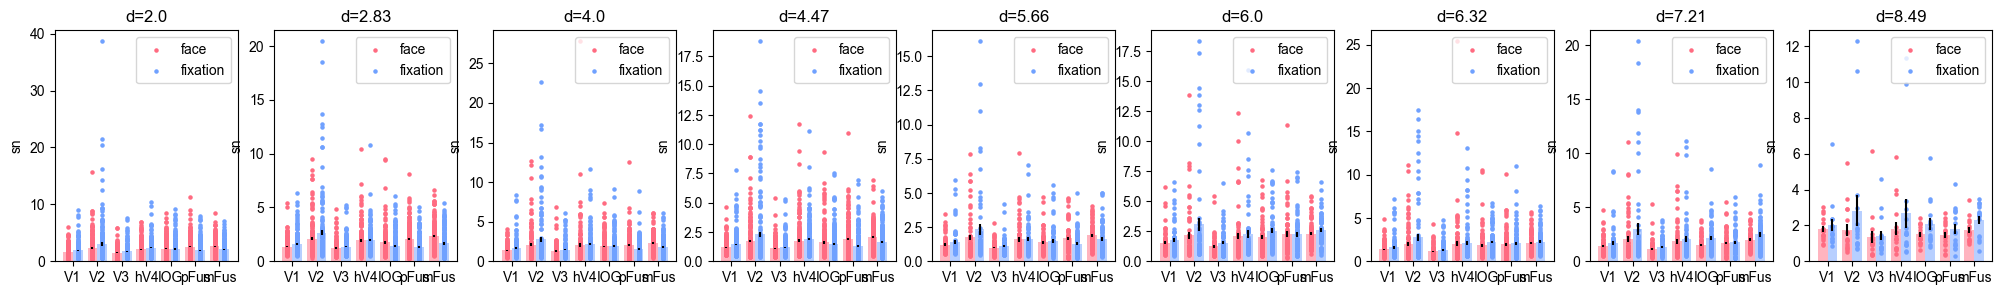

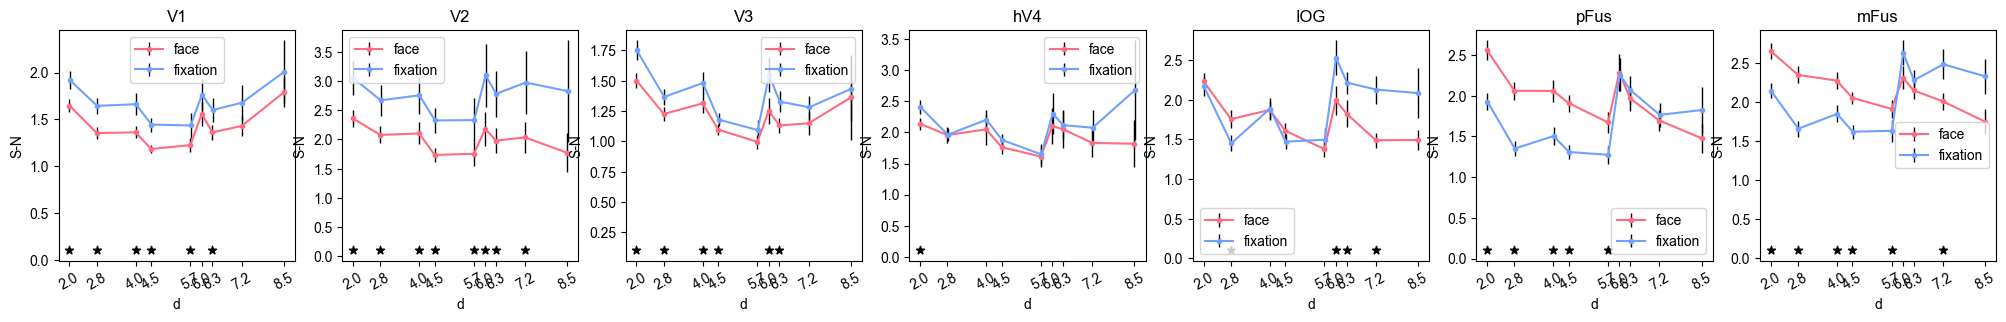

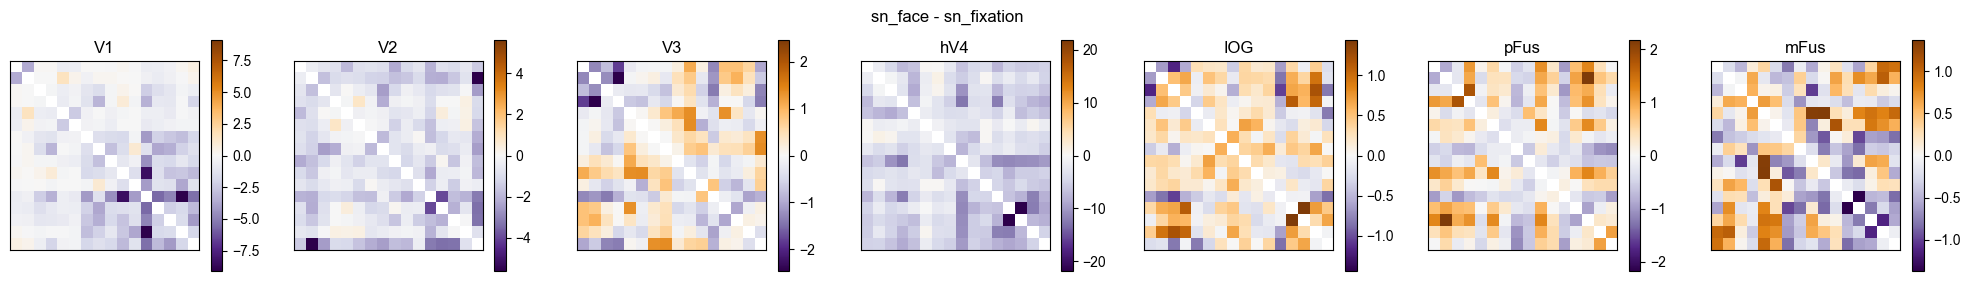

In [31]:
# sum(sn)
# bar
f=plt.figure(figsize=(25,3))
for dd in range(len(d)):
    plt.subplot(1,9,dd+1)
    mybarplot(snsum_d[dd,:,:,:],'mean','sem',cm,'','sn',roi_labels,tasks,'d='+str(round(d[dd],2)),1,0)

# signal-noise
f = plt.figure(figsize=(25,3))
cms = ['#ff6b81','#70a1ff']
for roi_i in range(len(roi_labels)):
    plt.subplot(1,7,roi_i+1)
    #for ipc in range(1): 
    plt.errorbar(d,np.nanmean(snsum_d[:,:,roi_i,0],axis=1),stats.sem(snsum_d[:,:,roi_i,0],axis=1,nan_policy='omit'),color=cm[0],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    plt.errorbar(d+0.01,np.nanmean(snsum_d[:,:,roi_i,1],axis=1),stats.sem(snsum_d[:,:,roi_i,1],axis=1,nan_policy='omit'),color=cm[1],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    
    plt.xticks(d,np.round(d,1),rotation=30)
    plt.ylabel('S-N');plt.xlabel('d')
    plt.title(roi_labels[roi_i])
    #plt.ylim([0,4])
    plt.legend(tasks)
    # t-test
    for dd in range(len(d)):
        [t,p]=ttest_rel(snsum_d[dd,:,roi_i,0], snsum_d[dd,:,roi_i,1],nan_policy='omit')
        if p<0.05:
            plt.scatter(d[dd],0.1,marker='*',c='k')    
        
# heatmap    
fig=plt.figure(figsize=(25,3))
fig.suptitle('sn_face - sn_fixation')  
for roi_i in range(len(roi_labels)):
    data=np.nanmean(snsum_ij_all[:,:,roi_i,0],axis=2)-np.nanmean(snsum_ij_all[:,:,roi_i,1],axis=2)
    ax=plt.subplot(1,7,roi_i+1)
    myheatmap(ax,data,'-+',None,None,None,[],[],roi_labels[roi_i],None,0)

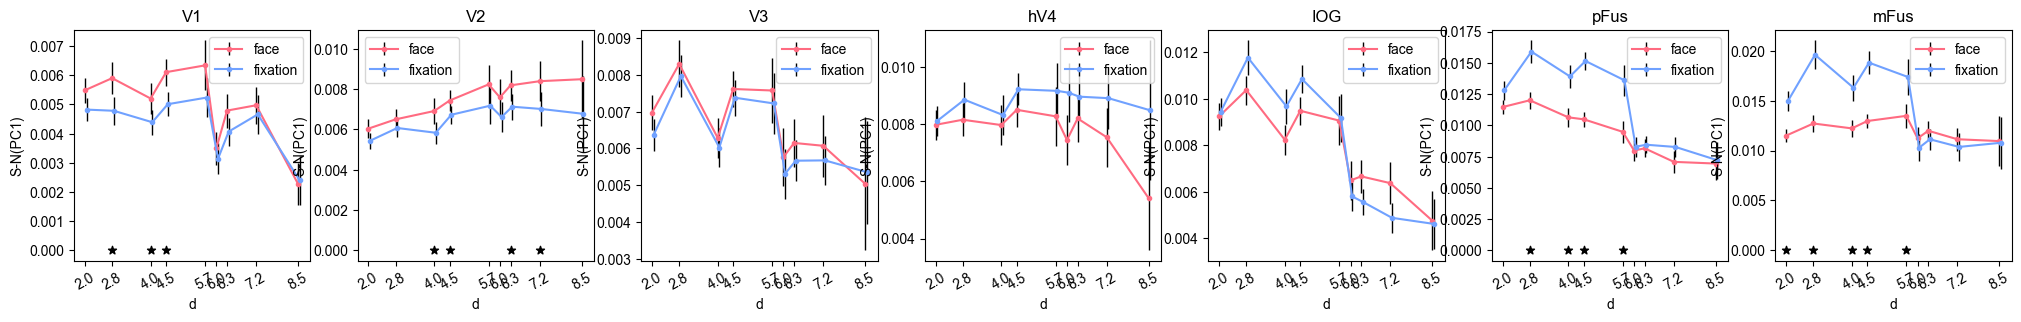

In [81]:
# PC1
f = plt.figure(figsize=(25,3))
cms = ['#ff6b81','#70a1ff']
for roi_i in range(len(roi_labels)):
    plt.subplot(1,7,roi_i+1)
    ipc=0
    plt.errorbar(d,np.nanmean(sn_d[ipc,:,:,roi_i,0],axis=1),stats.sem(sn_d[ipc,:,:,roi_i,0],axis=1,nan_policy='omit'),color=cm[0],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    plt.errorbar(d+0.05,np.nanmean(sn_d[ipc,:,:,roi_i,1],axis=1),stats.sem(sn_d[ipc,:,:,roi_i,1],axis=1,nan_policy='omit'),color=cm[1],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    
    plt.xticks(d,np.round(d,1),rotation=30)
    plt.ylabel('S-N(PC1)');plt.xlabel('d')
    plt.title(roi_labels[roi_i])
    #plt.ylim([0,4])
    plt.legend(tasks)
    # t-test
    for dd in range(len(d)):
        [t,p]=ttest_rel(sn_d[ipc,dd,:,roi_i,0], sn_d[ipc,dd,:,roi_i,1],nan_policy='omit')
        if p<0.05:
            plt.scatter(d[dd],0.0,marker='*',c='k')    
        

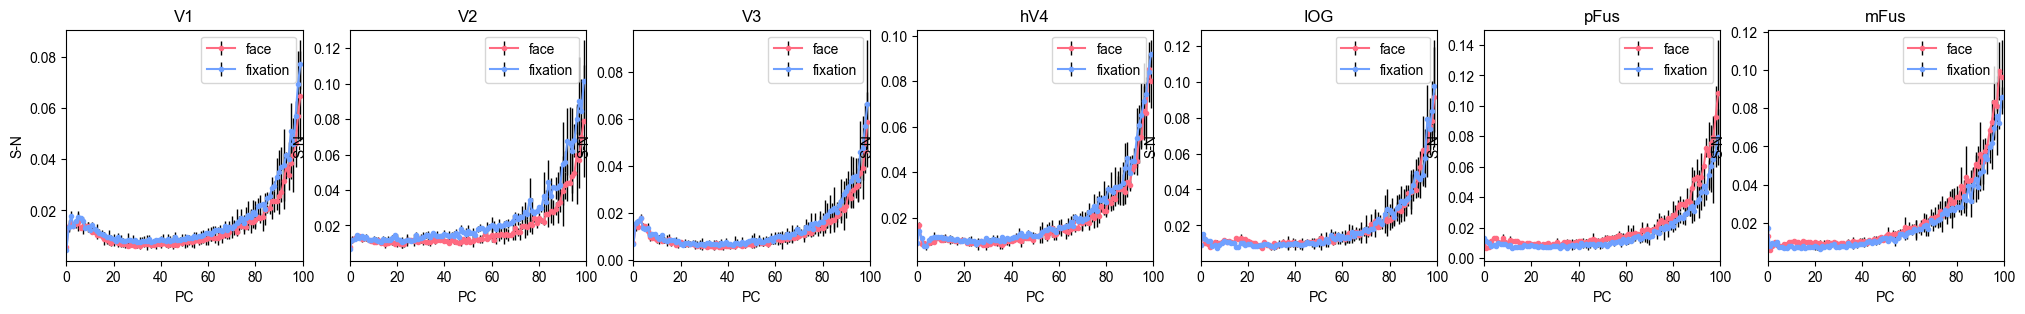

In [17]:
f = plt.figure(figsize=(25,3))
cms = ['#ff6b81','#70a1ff']
for roi_i in range(len(roi_labels)):
    plt.subplot(1,7,roi_i+1)
    plt.errorbar(np.arange(100),np.nanmean(sn_d[:,:,:,roi_i,0],axis=1).mean(axis=1),stats.sem(sn_d[:,:,:,roi_i,0].mean(axis=2),axis=1,nan_policy='omit'),color=cm[0],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    plt.errorbar(np.arange(100),np.nanmean(sn_d[:,:,:,roi_i,1],axis=1).mean(axis=1),stats.sem(sn_d[:,:,:,roi_i,1].mean(axis=2),axis=1,nan_policy='omit'),color=cm[1],marker='.',ecolor='k',elinewidth=1)#,alpha=1-0.1*ipc)
    plt.ylabel('S-N');plt.xlabel('PC')
    plt.title(roi_labels[roi_i])
    plt.xlim([0,100])
    plt.legend(tasks)


#### 3.4 signal rotation angle

$$
\theta = arccos(\frac{a b}{|a||b|})
$$

In [ ]:
# calculate
srangle_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels)))*np.nan # [npos(s1),npos(s2),nsubj,nroi]
for roi_i in range(len(roi_labels)):
    for subj_i in range(len(subjs)):
        stimposicond_face = stimposicond_all[0,subj_i,:]
        stimposicond_fix = stimposicond_all[1,subj_i,:]
        # beta for each position (trial-    by-trial)
        beta_face = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
        beta_fix = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
        beta_mean_face = np.zeros((nvoxel,npos))*np.nan
        beta_mean_fix = np.zeros((nvoxel,npos))*np.nan
        for pos in range(npos):
            beta_face[:,:,pos] = beta_all[0,roi_i,subj_i,:,stimposicond_face==pos+1].T
            beta_fix[:,:,pos] = beta_all[1,roi_i,subj_i,:,stimposicond_face==pos+1].T
            beta_mean_face[:,pos] = np.nanmean(beta_face[:,:,pos],axis=1)
            beta_mean_fix[:,pos] = np.nanmean(beta_fix[:,:,pos],axis=1)
        for s1 in range(npos-1):
            for s2 in range(s1,npos):
                df_face = beta_mean_face[:,s1]-beta_mean_face[:,s2]
                df_fix = beta_mean_fix[:,s1]-beta_mean_fix[:,s2]
                df_dotproduct = np.dot(df_face,df_fix)
                df_norm_face = np.linalg.norm(df_face)
                df_norm_fix = np.linalg.norm(df_fix)
                rot_deg = np.degrees(np.arccos(df_dotproduct/(df_norm_face*df_norm_fix)))
                srangle_ij_all[[s1,s2],[s2,s1],subj_i,roi_i] = rot_deg

# concat results by distance
srangle_d = np.zeros((len(d),nsample,len(roi_labels)))*np.nan # d x sample x roi
for roi_i in range(len(roi_labels)):
    for dd in range(len(d)):
        srangle_dd = np.array([])
        for subj_i in range(len(subjs)):
            srangle_dd = np.append(srangle_dd,srangle_ij_all[ds_list==d[dd],subj_i,roi_i])
        srangle_d[dd,0:len(srangle_dd),roi_i] = srangle_dd

# average srangle across position pairs for each distance for each subject
srangle_d_subj = np.zeros((len(d),nsubj,len(roi_labels)))*np.nan # d x subj x roi
for dd in range(len(d)):
    srangle_d_subj[dd,:,:] = np.nanmean(srangle_ij_all[ds_list==d[dd],:,:],axis=0)
    

np.savez('data/srangle',srangle_ij_all=srangle_ij_all,srangle_d=srangle_d,srangle_d_subj=srangle_d_subj)           

/tmp/ipykernel_2491651/4048848862.py:24: RuntimeWarning: invalid value encountered in scalar divide
  rot_deg = np.degrees(np.arccos(df_dotproduct/(df_norm_face*df_norm_fix)))


#### 3.5 PC rotation angle & variance

In [ ]:
# calculate
pcv_ij_all = np.zeros((nvoxel,npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npc,npos,npos,nsubj,nroi,ntask]
pcvi_ij_all = np.zeros((nvoxel,npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [npc,npos,npos,nsubj,nroi,ntask]
vec_ij_all = np.zeros((nvoxel,nvoxel,npos,npos,nsubj,len(roi_labels),len(tasks)))*np.nan # [eigenvector,npc,npos,npos,nsubj,nroi,ntask]
cwangle_ij_all = np.zeros((nvoxel,npos,npos,nsubj,len(roi_labels)))*np.nan # [npc,npos,npos,nsubj,nroi]
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            # beta for each position (trial-by-trial)
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                beta_mean[:,pos] = np.nanmean(beta[:,:,pos],axis=1)
            for s1 in range(npos):
                for s2 in range(s1+1,npos):
                    # eigenvector & eigenvalue
                    q1 = np.cov(beta[:,:,s1])
                    q2 = np.cov(beta[:,:,s2])
                    q = (q1 + q2)/2 # 100 x 100

                    w,v = np.linalg.eigh(q)
                    sorted_res = sorted(enumerate(w), key=lambda x: x[1],reverse=True)
                    sorted_w = [x[1] for x in sorted_res]
                    sorted_n = [x[0] for x in sorted_res]
                    pcv_ij_all[:len(sorted_w),s1,s2,subj_i,roi_i,task_i] = sorted_w
                    pcv_ij_all[:len(sorted_w),s2,s1,subj_i,roi_i,task_i] = sorted_w
                    pcvi_ij_all[:len(sorted_w),s1,s2,subj_i,roi_i,task_i] = sorted_w/np.nanmean(w)
                    pcvi_ij_all[:len(sorted_w),s2,s1,subj_i,roi_i,task_i] = sorted_w/np.nanmean(w)
                    vec_ij_all[:len(sorted_w),:len(sorted_w),s1,s2,subj_i,roi_i,task_i] = v[:,sorted_n]
                    vec_ij_all[:len(sorted_w),:len(sorted_w),s2,s1,subj_i,roi_i,task_i] = v[:,sorted_n]

for roi_i in range(len(roi_labels)):
    for subj_i in range(len(subjs)):
        for s1 in range(npos-1):
            for s2 in range(s1+1,npos):
                for npc in range(nvoxel):
                    ev_face = vec_ij_all[:,npc,s1,s2,subj_i,roi_i,0]
                    ev_fix = vec_ij_all[:,npc,s1,s2,subj_i,roi_i,1]
                    ev_dotproduct = np.dot(ev_face,ev_fix)
                    ev_norm_face = np.linalg.norm(ev_face)
                    ev_norm_fix = np.linalg.norm(ev_fix)
                    crot_deg = np.degrees(np.arccos(ev_dotproduct/(ev_norm_face*ev_norm_fix)))
                    cwangle_ij_all[npc,[s1,s2],[s2,s1],subj_i,roi_i] = crot_deg if crot_deg<90 else 180-crot_deg
                    #cwangle_ij_all[npc,[s1,s2],[s2,s1],subj_i,roi_i] = crot_deg

# concat results by distance
cwangle_d = np.zeros((nvoxel,len(d),nsample,len(roi_labels)))*np.nan # pc x d x sample x roi
for roi_i in range(len(roi_labels)):
    for dd in range(len(d)):
        cwangle_dd = np.empty((nvoxel,0))
        for subj_i in range(len(subjs)):
            cwangle_dd = np.append(cwangle_dd,cwangle_ij_all[:,ds_list==d[dd],subj_i,roi_i],axis=1)
        cwangle_d[:,dd,0:cwangle_dd.shape[1],roi_i] = cwangle_dd

pcv_d = np.zeros((nvoxel,len(d),nsample,len(roi_labels),len(tasks)))*np.nan # pc x d x sample x roi
pcvi_d = np.zeros((nvoxel,len(d),nsample,len(roi_labels),len(tasks)))*np.nan # pc x d x sample x roi
for task_i in range(2):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            pcv_dd = np.empty((nvoxel,0))
            pcvi_dd = np.empty((nvoxel,0))
            for subj_i in range(len(subjs)):
                pcv_dd = np.append(pcv_dd,pcv_ij_all[:,ds_list==d[dd],subj_i,roi_i,task_i],axis=1)
                pcvi_dd = np.append(pcvi_dd,pcvi_ij_all[:,ds_list==d[dd],subj_i,roi_i,task_i],axis=1)
            pcv_d[:,dd,0:pcv_dd.shape[1],roi_i,task_i] = pcv_dd
            pcvi_d[:,dd,0:pcvi_dd.shape[1],roi_i,task_i] = pcvi_dd


# average data across position pairs for each distance for each subject
pcv_d_subj = np.zeros((nvoxel,len(d),nsubj,len(roi_labels),len(tasks)))*np.nan # npc x d x subj x roi x task
pcvi_d_subj = np.zeros((nvoxel,len(d),nsubj,len(roi_labels),len(tasks)))*np.nan
cwangle_d_subj = np.zeros((nvoxel,len(d),nsubj,len(roi_labels)))*np.nan # npc x d x subj x roi
for dd in range(len(d)):
    pcv_d_subj[:,dd,:,:,:] = np.nanmean(pcv_ij_all[:,ds_list==d[dd],:,:,:],axis=1)
    pcvi_d_subj[:,dd,:,:,:] = np.nanmean(pcvi_ij_all[:,ds_list==d[dd],:,:,:],axis=1)
    cwangle_d_subj[:,dd,:,:] = np.nanmean(cwangle_ij_all[:,ds_list==d[dd],:,:],axis=1)

np.savez('data/cwangle',pcv_ij_all=pcv_ij_all,cwangle_ij_all=cwangle_ij_all,cwangle_d=cwangle_d,pcv_d=pcv_d,
         pcvi_d=pcvi_d,pcvi_ij_all=pcvi_ij_all,
         pcv_d_subj=pcv_d_subj,pcvi_d_subj=pcvi_d_subj,cwangle_d_subj=cwangle_d_subj)   

### 4 LFI: four mechanisms

In [ ]:
def cal_lfi_param(beta_mean_cond,beta_cond,s1,s2):
    # ds
    dr = s1//4-s2//4
    dc = s1%4-s2%4
    ds = ds0 *  (dr**2+dc**2)**0.5
    # df & |dfnorm|
    df = np.mat(beta_mean_cond[:,s1] - beta_mean_cond[:,s2])

    dfnorm = np.linalg.norm(df,axis=1)
    # eigenvector & eigenvalue
    q1 = np.cov(beta_cond[:,:,s1])
    q2 = np.cov(beta_cond[:,:,s2])
    q = (q1 + q2)/2 # 100 x 100

    w,v = np.linalg.eigh(q)
    ullambda = np.nanmean(w)
    htlambda = w/ullambda
    return ds,df,dfnorm,v,ullambda,htlambda

def cal_lfi(ds,dfnorm,ullambda,df_dfnorm,v,htlambda,bc=True,ntrialperpos=ntrialperpos, nvoxel=nvoxel):
    I = 1/(ds)**2*dfnorm**2/ullambda*np.nansum([(df_dfnorm@v[:,i])**2/htlambda[i] for i in range(len(htlambda))])
    if bc:
        I_bc = I*(2*ntrialperpos-nvoxel-3)/(2*ntrialperpos-2)-(2*nvoxel)/(ntrialperpos*(ds)**2)
        return I_bc
    else:
        return I

def cal_lfi_log(ds,dfnorm,ullambda,df_dfnorm,v,htlambda,bc=True,ntrialperpos=ntrialperpos, nvoxel=nvoxel):
    I = cal_lfi(ds,dfnorm,ullambda,df_dfnorm,v,htlambda,bc,ntrialperpos, nvoxel)
    return np.log(I)

#### 4.0 separate

In [ ]:
# calculate
Ilog_stw_ij_all = np.zeros((npos,npos,nsubj,len(roi_labels),5))*np.nan # [npos(s1),npos(s2),nsubj,nroi,ntype]
for roi_i in range(len(roi_labels)):
    for subj_i in range(len(subjs)):
        stimposicond_unatt = stimposicond_all[1,subj_i,:]
        stimposicond_att = stimposicond_all[0,subj_i,:]
        # beta for each position (trial-by-trial)
        beta_digit_all = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
        beta_digit_mean_all = np.zeros((nvoxel,npos))*np.nan
        beta_face_all = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
        beta_face_mean_all = np.zeros((nvoxel,npos))*np.nan
        for pos in range(npos):
            beta_digit_all[:,:,pos] = beta_all[1,roi_i,subj_i,:,stimposicond_unatt==pos+1].T
            beta_digit_mean_all[:,pos] = np.nanmean(beta_digit_all[:,:,pos],axis=1)
            beta_face_all[:,:,pos] = beta_all[0,roi_i,subj_i,:,stimposicond_att==pos+1].T
            beta_face_mean_all[:,pos] = np.nanmean(beta_face_all[:,:,pos],axis=1)
        for s1 in range(npos-1):
            for s2 in range(s1+1,npos):
                ds,df_digit,dfnorm_digit,v_digit,ullambda_digit,htlambda_digit = cal_lfi_param(beta_digit_mean_all,beta_digit_all,s1,s2)
                ds,df_face,dfnorm_face,v_face,ullambda_face,htlambda_face = cal_lfi_param(beta_face_mean_all,beta_face_all,s1,s2)
                # I_digit   I_se    I_ms I_sr,mw  I_face
                Ilog_stw_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,0] = cal_lfi_log(ds,dfnorm_digit,ullambda_digit,df_digit/dfnorm_digit,v_digit,htlambda_digit,bc=False)
                Ilog_stw_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,1] = cal_lfi_log(ds,dfnorm_face,ullambda_digit,df_digit/dfnorm_digit,v_digit,htlambda_digit,bc=False)
                Ilog_stw_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,2] = cal_lfi_log(ds,dfnorm_digit,ullambda_face,df_digit/dfnorm_digit,v_digit,htlambda_digit,bc=False)
                Ilog_stw_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,3] = cal_lfi_log(ds,dfnorm_digit,ullambda_digit,df_face/dfnorm_face,v_face,htlambda_face,bc=False)
                Ilog_stw_ij_all[[s1,s2],[s2,s1],subj_i,roi_i,4] = cal_lfi_log(ds,dfnorm_face,ullambda_face,df_face/dfnorm_face,v_face,htlambda_face,bc=False)

i_types = ['digit','se','ms','srmw','face']
# concat reuslts by distance
Ilog_stw_d = np.zeros((len(d),nsample,len(roi_labels),5))*np.nan # d x sample x roi x type
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for dd in range(len(d)):
            Ilog = {'digit':np.array([]),'se':np.array([]),'ms':np.array([]),'srmw':np.array([]),'face':np.array([])}
            for subj_i in range(len(subjs)):
                for i in range(5):
                    Ilog[i_types[i]] = np.append(Ilog[i_types[i]],Ilog_stw_ij_all[ds_list==d[dd],subj_i,roi_i,i])
                    Ilog_stw_d[dd,0:len(Ilog[i_types[i]]),roi_i,i] = Ilog[i_types[i]]

deltaIlog_stw_d = Ilog_stw_d[:,:,:,1:]-Ilog_stw_d[:,:,:,[0]] # d x sample x roi x type

Ilog_stw_d_subj = np.zeros((len(d),nsubj,len(roi_labels),5))*np.nan # d x subj x roi x task
for dd in range(len(d)):
    Ilog_stw_d_subj[dd,:,:,:] = np.nanmean(Ilog_stw_ij_all[ds_list==d[dd],:,:,:],axis=0)
deltaIlog_stw_d_subj = Ilog_stw_d_subj[:,:,:,1:]-Ilog_stw_d_subj[:,:,:,[0]]# d x subj x roi x type

np.savez('data/LFI_separate',Ilog_stw_d=Ilog_stw_d,Ilog_stw_ij_all=Ilog_stw_ij_all,deltaIlog_stw_d=deltaIlog_stw_d,
         Ilog_stw_d_subj=Ilog_stw_d_subj,deltaIlog_stw_d_subj=deltaIlog_stw_d_subj)  


### 5 other analysis (supplementary)

#### 5.1 signal & noise correlation

signal correlation

In [ ]:
# signal corr
# calculate
signal_corr_all = np.zeros([math.comb(nvoxel,2),len(roi_labels),len(tasks),nsubj])*np.nan
for task_i in range(len(tasks)):
    for roi_i in range(len(roi_labels)):
        for subj_i in range(nsubj):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            for pos in range(npos):
                beta_mean[:,pos] = np.nanmean(beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T,axis=1)
            sc = np.corrcoef(beta_mean[:,:]) # 100 x 100
            signal_corr_all[:,roi_i,task_i,subj_i] = sc[np.triu_indices(nvoxel,k=1)]
np.savez('data/sig_corr',signal_corr_all=signal_corr_all)  

noise correlation

In [ ]:
# calculate
noise_p_corr_all = np.zeros([npos,math.comb(nvoxel,2),len(roi_labels),len(tasks),nsubj])*np.nan
for subj_i in range(nsubj):
    for task_i in range(len(tasks)):
        for roi_i in range(len(roi_labels)):
            stimposicond = stimposicond_all[task_i,subj_i,:]
            beta_mean = np.zeros((nvoxel,npos))*np.nan
            beta = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            for pos in range(npos):
                beta[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond==pos+1].T
                nc = np.corrcoef(beta[:,:,pos]) # 100 x 100
                noise_p_corr_all[pos,:,roi_i,task_i,subj_i] = nc[np.triu_indices(nvoxel,k=1)]
noise_corr_all = np.nanmedian(noise_p_corr_all,axis=0)
np.savez('data/noise_corr',noise_p_corr_all=noise_p_corr_all,noise_corr_all=noise_corr_all)  

#### 5.2 shuffle correlation

In [ ]:
def runsvm(pi,clf,y,sfl_n,sfl_type='ori',save=True):
    # sfl_type: 'ori' or 'sfld'
    acc_ij_face = np.zeros((sfl_n,npos,npos,nsubj,len(roi_labels)))*np.nan # [nshuffle,npos(s1),npos(s2),nsubj,nroi]
    idx0 = np.arange(0,ntrial)
    task_i = 0
    for roi_i in range(len(roi_labels)):
        for subj_i in range(len(subjs)):
            print('pi{},roi{},subj{}'.format(pi,roi_i,subj_i))
            stimposicond0 = stimposicond_all[task_i,subj_i,:].copy() # trial
            beta0 = np.zeros((nvoxel,ntrialperpos,npos))*np.nan # voxel x trial x position
            for pos in range(npos):
                beta0[:,:,pos] = beta_all[task_i,roi_i,subj_i,:,stimposicond0==pos+1].T  
            # shuffle
            beta_sfl = beta0.copy()
            for i in tqdm(range(sfl_n)):
                if sfl_type == 'ori':
                    for pos in range(npos):
                        idx = np.arange(0,ntrialperpos)
                        np.random.shuffle(idx)
                        beta_sfl[:,:,pos] = beta0[:,idx,pos]      
                elif sfl_type == 'sfld':
                    for pos in range(npos):
                        beta_sfl[:,:,pos] = beta0[np.arange(nvoxel)[:, None], np.argsort(np.random.rand(nvoxel, ntrialperpos), axis=1),pos]
                # classification
                for s1 in range(npos):
                    for s2 in range(s1,npos):  
                        X = np.hstack([beta_sfl[:,:,s1],beta_sfl[:,:,s2]]).T
                        X = X[:,~np.isnan(X).any(axis=0)]
                        scores = cross_val_score(clf,X,y,cv=10,n_jobs=35)
                        acc_ij_face[i,[s1,s2],[s2,s1],subj_i,roi_i] = np.array([scores.mean(),scores.mean()])
    return acc_ij_face

def parallel_shuffle(clf,y,sfl_n,sfl_type='ori',save=True):
    results = Parallel(n_jobs=-1)(delayed(runsvm)(pi,clf,y,sfl_n,sfl_type,save) for pi in range(npall))
    acc_ij_face = np.concatenate(results, axis=0)

    # save                        
    if save: np.savez('data/svmacc_shuffle_'+sfl_type,acc_ij_face=acc_ij_face)  

    return acc_ij_face
  

In [ ]:
# set
seed = 1234
np.random.seed(seed)
random.seed(seed)
clf = svm.SVC(C=1,kernel='linear',gamma='scale',degree=3)
y = np.hstack([np.zeros(ntrialperpos),np.zeros(ntrialperpos)+1])
sfl_total = 1000
npall = 20
sfl_n = int(sfl_total/npall)
sfl_types = ['ori','sfld']
sfl_idx = 1

# run 
acc_ij_face = parallel_shuffle(clf,y,sfl_n,sfl_type=sfl_types[sfl_idx],save=True)
